# Notiz für Henry:
diese Datei ist dafür da das Neuronale Netz zu entwickeln. In einem Notebook kann man schneller Hyperparameter ändern und einfacher weitere kleine Änderungen vornehmen. Wenn das Gröbste steht können wir das Notebook einfach als .py Datei exportieren und sind happy

Korrelationen für Pop

Cluster in Pop?

Pop in Cluster aufteilen

eventuell auch mit Rock?

Hyperparameter optimieren

## Importieren der wichtigsten Pakete

In [1]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

2023-07-08 13:23:12.616040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# GPU Test
import tensorflow as tf

# Funktioniert momentan bei mir immernoch nicht
#if tf.test.is_gpu_available():
#   print("GPU is available")
#   print("GPU(s) that Tensorflow recognizes:", tf.config.list_physical_devices('GPU'))
#else:
#   print("GPU not available")
# Manuell auf CPU einschränken
tf.config.set_visible_devices([], 'GPU')

## Sinnvolle Funktionen

In [3]:
################################################################################################### 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f'{cm[i, j]:.3f}'  # Runde den Wert auf 3 Dezimalstellen
        plt.text(j, i, value,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[n]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[n],obs_errors[n]))
            n += 1
            
################################################################################################### 

In [4]:
def evaluate(X_test, Y_test):
    # Make predictions on test data
    Y_pred = model.predict(X_test)
    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"loss:     {loss:.3}")
    print(f"accuracy: {accuracy:.3}")

    # Compute the classification report
    report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    print(report)
    
    # Plot probability of being zero for true !genre! and non-!genre!
    true_genre = np.where(np.argmax(Y_test, axis=1) == 0)[0]
    true_non_genre = np.where(np.argmax(Y_test, axis=1) != 0)[0]
    
    plt.figure()
    plt.hist(Y_pred[true_genre, 0], bins=50, color='red', label='True !genre!', alpha=0.5)
    plt.hist(Y_pred[true_non_genre, 0], bins=50, color='blue', label='True Non-!genre!', alpha=0.5)
    plt.xlabel('Probability of !hier genre einfügen!')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(confusion_mtx, classes=range(10), normalize='true')  

## Laden der Daten
Am besten wir fügen das Genre in einer separaten Datei dem Datensatz hinzu und machen ab hier nur mit dem fertigen Datensatz weiter

## Convert target

In [5]:
#csv_file = "../data/data_selected.csv"
csv_file = "../data/data_selected_v1.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments',
       'Stream', 'Genre', 'Artist_encoded', 'Album_type_encoded',
       'Licensed_encoded', 'official_video_encoded'],
      dtype='object')

In [6]:
df = df.loc[~df["Genre"].isin(["bullshit"])]
#df = df.loc[~df["Genre"].isin(["country"])]
#df = df.loc[~df["Genre"].isin(["raggae"])]
#df = df.loc[~df["Genre"].isin(["rock"])]
#df = df.loc[~df["Genre"].isin(["soul"])]
#df = df.loc[~df["Genre"].isin(["folk"])]
#df = df.loc[~df["Genre"].isin(["pop"])]

genres_to_keep = ["classic", "metal", "rock", "hip hop", "electronic", "pop"]
df = df[df['Genre'].isin(genres_to_keep)]

n=100
genre_counts = df["Genre"].value_counts()
df= df[df["Genre"].isin(genre_counts[genre_counts > n].index)]

In [7]:
features_drop = ['Genre', 'Unnamed: 0']

df = df.sample(frac=1, random_state=42) #daten mischen

X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [8]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)

# label um One-Hot-Encoding hinterher wieder zu übersetzen
genre_mapping = Y.columns
label = []
for index, genre in enumerate(genre_mapping):
    label.append(genre)
    print("Genre", index, ":", genre)


Genre 0 : classic
Genre 1 : electronic
Genre 2 : hip hop
Genre 3 : metal
Genre 4 : pop
Genre 5 : rock


## Splitten von Training und Test Datensätzen

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.3, stratify=Y_train, random_state=42)

In [10]:
#from sklearn.model_selection import StratifiedShuffleSplit

# Erstellen Sie den StratifiedShuffleSplit-Teiler
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Verwenden Sie den Teiler, um Ihre Daten in Trainings- und Testsets aufzuteilen.
#for train_index, test_index in sss.split(X, Y):
#    X_train, X_test = X[train_index], X[test_index]
#    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Erstellen Sie einen zweiten StratifiedShuffleSplit-Teiler für das Validierungsset
#    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    
#    for train_index, val_index in sss_val.split(X_train, Y_train):
#        X_train, X_val = X_train[train_index], X_train[val_index]
#        Y_train, Y_val = Y_train[train_index], Y_train[val_index]


## Daten skalieren

In [11]:
#scaler = StandardScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

## Daten transformieren und skalieren

In [ ]:
# Fit NUR auf train...
transformer = QuantileTransformer(output_distribution="normal")
transformer.fit(X_train)

# ... dann transform auf alle
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

# Werte der Attribute mit MinMax auf [-1,1] skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit wieder auf train...
scaler.fit(X_train)

# ... dann wieder transform
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Gewichte berechnen um Überrepräsentation zu vermeiden

In [12]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(Y.value_counts())
class_counts = np.sum(Y_train, axis=0)
total_samples = np.sum(class_counts)
class_weights = total_samples / (num_classes * class_counts)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Anpassung der Gewichte auf das One-Hot-kodierte Y_train
Y_train_encoded = np.argmax(Y_train, axis=1)
sample_weights = np.array([class_weights_dict[class_label] for class_label in Y_train_encoded])

# Transformieren, damit die wichtigsten Klassen nicht unterrepräsentiert sind 
# TODO: finde eine gute Funktion dafür
#transformed_weights = np.log(sample_weights + 1) #log acc~25% -> funktioniert glaube ich am besten
#transformed_weights = sample_weights ** 2 # square acc~10% -> der ist ziemlich kacke
#transformed_weights = np.exp(sample_weights) # exp acc~7%
transformed_weights = 1 / (1 + np.exp(-sample_weights)) #sigmoid acc~40%


## Modell
hier ein schönes Modell ergänzen

In [13]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               1

## Training

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 32
nb_epoch = 300

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', min_lr=1e-7)

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
#hist = model.fit(X_train, Y_train, sample_weight=transformed_weights, validation_data=(X_val, Y_val), 
#                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

Epoch 1/300
99/99 [==============================] - 1s 3ms/step - loss: 1.5918 - accuracy: 0.3556 - val_loss: 1.3512 - val_accuracy: 0.4682 - lr: 0.0010
Epoch 2/300
99/99 [==============================] - 0s 2ms/step - loss: 1.3967 - accuracy: 0.4417 - val_loss: 1.1560 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/300
99/99 [==============================] - 0s 2ms/step - loss: 1.2783 - accuracy: 0.5038 - val_loss: 1.1058 - val_accuracy: 0.5849 - lr: 0.0010
Epoch 4/300
99/99 [==============================] - 0s 2ms/step - loss: 1.2194 - accuracy: 0.5206 - val_loss: 1.0492 - val_accuracy: 0.5894 - lr: 0.0010
Epoch 5/300
99/99 [==============================] - 0s 2ms/step - loss: 1.1828 - accuracy: 0.5222 - val_loss: 1.0211 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 6/300
99/99 [==============================] - 0s 2ms/step - loss: 1.1578 - accuracy: 0.5513 - val_loss: 1.0259 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 7/300
99/99 [==============================] - 0s 2ms/step - loss: 1.1

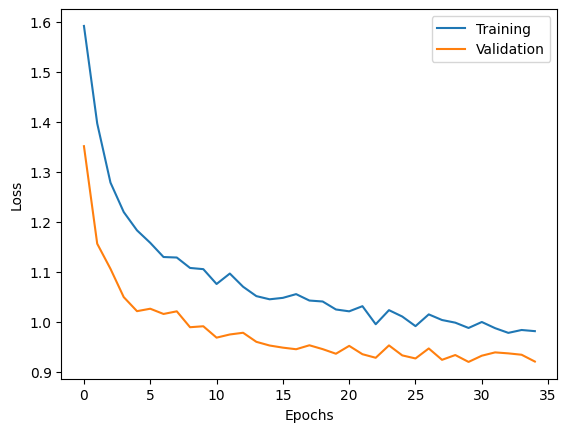

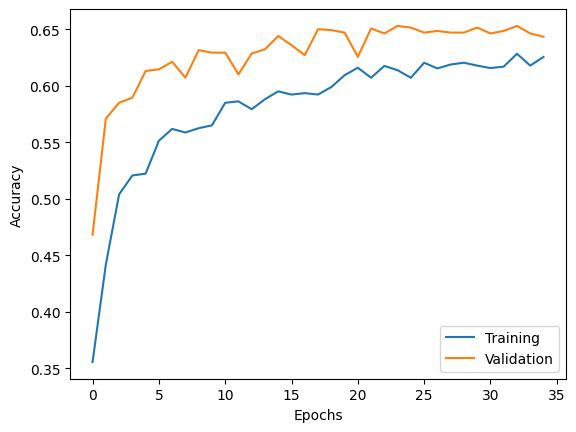

In [16]:
plot_history(hist)

## Vorhersage

In [17]:
Y_pred = model.predict(X_test)

61/61 [==============================] - 0s 510us/step


In [18]:
#import matplotlib.pyplot as plt
#
#for i in range(len(label)):
#    genre = label[i]
#    probabilities = Y_pred[:, i]
    
#    plt.figure()
#    plt.hist(probabilities, bins=50)
#    plt.xlabel('Wahrscheinlichkeit')
#    plt.ylabel('Anzahl der Vorhersagen')
#    plt.yscale("log")
#    plt.title(f'Genre: {genre}')


## Evaluation

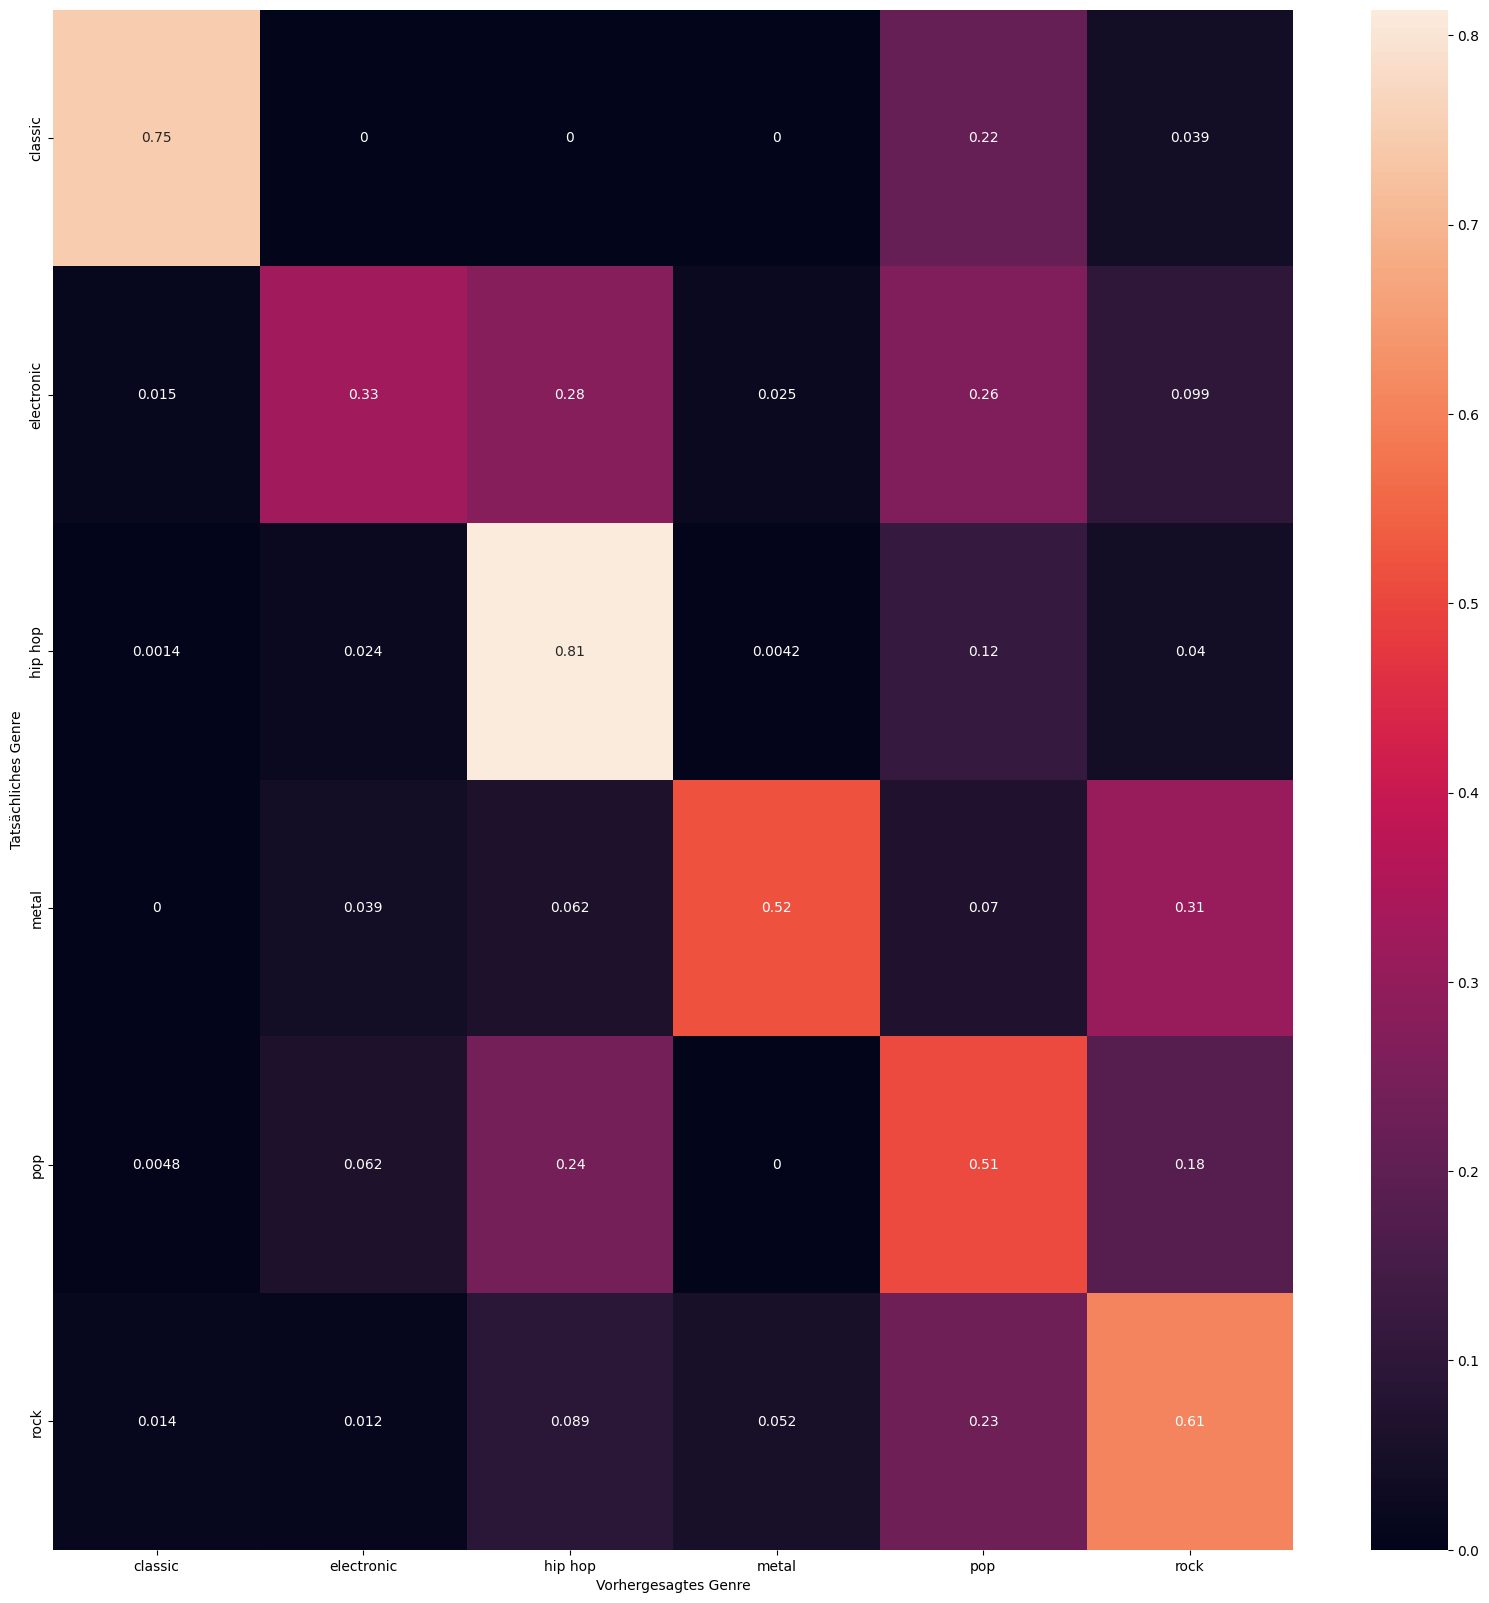

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

for i in range(len(Y_pred_classes)):
    if label[Y_pred_classes[i]] == 'pop' and Y_pred[i, Y_pred_classes[i]] > 0.9:
        # Finde den Index des zweithöchsten Werts
        second_highest_index = np.argsort(Y_pred[i])[-2]
        Y_pred_classes[i] = second_highest_index
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.savefig('../figures/confusion_matrix.png')
plt.show()


       classic  electronic  hip hop  metal    pop   rock
8189     False       False     True  False  False  False
11337    False       False    False   True  False  False
2094     False       False    False  False  False   True
1793     False       False     True  False  False  False
8780     False       False     True  False  False  False
...        ...         ...      ...    ...    ...    ...
11279    False       False    False   True  False  False
7298     False       False    False  False   True  False
8744     False       False     True  False  False  False
6673     False       False    False  False   True  False
3276     False       False     True  False  False  False

[1934 rows x 6 columns]
[[1.8597359e-02 8.4829800e-02 2.0456757e-01 2.6522864e-02 4.7237274e-01
  1.9310966e-01]
 [2.6081159e-04 2.7269343e-02 4.1622479e-02 6.3919264e-01 2.8355900e-02
  2.6329893e-01]
 [1.6597496e-02 3.0753572e-02 4.8475005e-02 3.5083283e-02 3.8651127e-01
  4.8257935e-01]
 ...
 [1.8937178e-03 7.8

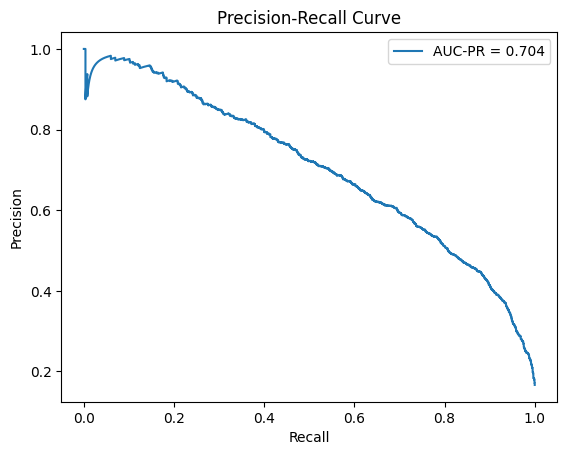

In [20]:
# Precision-Recall Curve
#-> die sollte eigentlich anders aussehen...

from sklearn.metrics import precision_recall_curve, auc

Y_prob = Y_pred

print(Y_test)
print(Y_prob)

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_prob, pd.DataFrame):
    Y_prob = Y_prob.values

print(Y_test.ravel())
print(Y_prob.ravel())

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()


hip hop: AUC-PR = 0.853
classic: AUC-PR = 0.769
rock: AUC-PR = 0.647
metal: AUC-PR = 0.604
pop: AUC-PR = 0.469
electronic: AUC-PR = 0.467


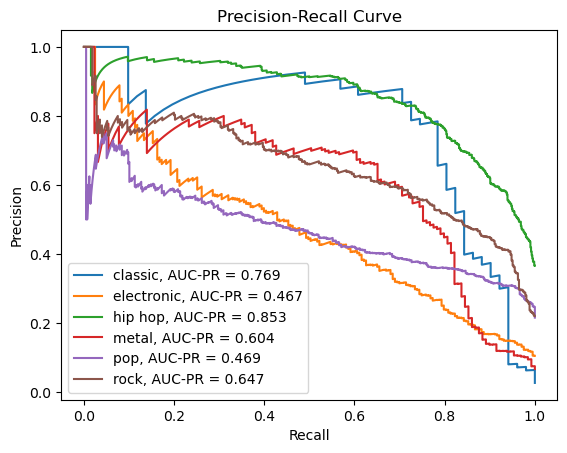

In [47]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")

## Hyperparameter Optimierung 

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model_from_params(params):
    num_hidden_layers = params['num_hidden_layers']
    activation_function = params['activation_function']
    dropout_rate = params['dropout_rate']
    units_per_layer = [params['units_1'],params['units_2'],params['units_3'],params['units_4']]

    model = Sequential()
    model.add(Dense(units=units_per_layer[0], activation=activation_function, input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))

    for i in range(1, num_hidden_layers+1):
        if i < len(units_per_layer):
            model.add(Dense(units=units_per_layer[i], activation=activation_function))
            model.add(Dropout(dropout_rate))

    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model



In [49]:

param_space = {
    'num_hidden_layers': [2, 3],
    'activation_function': ['LeakyReLU'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'units_1': [64, 128, 256],
    'units_2': [128, 256, 512],
    'units_3': [256, 512, 1024],
    'units_4': [512, 1024],
}
#param_space = {
#    'units_1': [64, 128, 256],
#    'units_2': [128, 256, 512],
#    'units_3': [256, 512, 1024],
#    'units_4': [512, 1024, 2048],
#    'dropout_rate': [0.3, 0.5],
#    'activation_function' : ['LeakyReLU'] # LeakyReLU verbessert val_acc, train_acc und senkt delta_acc
#}


value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 324 combinations:
[{'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 256, 'units_4': 512}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 256, 'units_4': 1024}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 512, 'units_4': 512}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 512, 'units_4': 1024}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 1024, 'units_4': 512}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 1024, 'units_4': 1024}, {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3,

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold

search_results = []

k_folds = 3
skf = StratifiedKFold(n_splits=k_folds)

for idx, params in enumerate(param_combis):
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")
    
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []
    
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, np.argmax(Y_train, axis=1))):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train.reset_index(drop=True).iloc[train_index], Y_train.reset_index(drop=True).iloc[val_index]
        
        filepath = f"../model_fold/model_fold_{idx+1}_fold_{fold_idx+1}.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
        this_model = build_model_from_params(params)
        
        fit_results = this_model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), 
                                     epochs=10, batch_size=512, callbacks=[checkpoint], verbose=0)
        
        # Extract the best validation scores
        best_val_epoch = np.argmax(fit_results.history['val_accuracy'])
        val_accuracies.append(np.max(fit_results.history['val_accuracy']))
        val_losses.append(fit_results.history['val_loss'][best_val_epoch])
        
        # Get training accuracy and loss
        best_model = load_model(filepath)
        train_loss, train_acc = best_model.evaluate(X_train_fold, Y_train_fold)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
    
    # Store results
    search_results.append({
        **params,
        'best_val_accuracy': np.mean(val_accuracies),
        'val_accuracy_std': np.std(val_accuracies),
        'best_val_loss': np.mean(val_losses),
        'val_loss_std': np.std(val_losses),
        'best_train_accuracy': np.mean(train_accuracies),
        'train_accuracy_std': np.std(train_accuracies),
        'best_train_loss': np.mean(train_losses),
        'train_loss_std': np.std(train_losses)
    })


Start run 1/324: Parameters: {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 256, 'units_4': 512}
66/66 [==============================] - 0s 808us/step - loss: 1.0172 - accuracy: 0.6059
Start run 2/324: Parameters: {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 256, 'units_4': 1024}
66/66 [==============================] - 0s 742us/step - loss: 1.0486 - accuracy: 0.6111
Start run 3/324: Parameters: {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 512, 'units_4': 512}
66/66 [==============================] - 0s 915us/step - loss: 1.0088 - accuracy: 0.6154
Start run 4/324: Parameters: {'num_hidden_layers': 2, 'activation_function': 'LeakyReLU', 'dropout_rate': 0.3, 'units_1': 64, 'units_2': 128, 'units_3': 512, 'units_4': 1024}
66/66 [============================

In [51]:
resultsDF = pd.DataFrame(search_results)
resultsDF['delta_acc'] = (resultsDF['best_train_accuracy']-resultsDF['best_val_accuracy'])/resultsDF['best_val_accuracy']
resultsDF.to_csv('../data/optimization_results20.csv', index=False)
resultsDF = pd.read_csv('../data/optimization_results20.csv')
resultsDF.head()

,num_hidden_layers,activation_function,dropout_rate,units_1,units_2,units_3,units_4,best_val_accuracy,val_accuracy_std,best_val_loss,val_loss_std,best_train_accuracy,train_accuracy_std,best_train_loss,train_loss_std,delta_acc
0,2,LeakyReLU,0.3,64,128,256,512,0.613050,0.010747,1.039888,0.022492,0.622232,0.015086,1.000091,0.019613,0.014978
1,2,LeakyReLU,0.3,64,128,256,1024,0.605453,0.014144,1.046205,0.013187,0.623815,0.009569,1.009427,0.027666,0.030328
2,2,LeakyReLU,0.3,64,128,512,512,0.618752,0.017846,1.031961,0.041216,0.618430,0.008801,0.999034,0.027245,-0.000521
3,2,LeakyReLU,0.3,64,128,512,1024,0.611471,0.022992,1.026147,0.022235,0.625555,0.007644,0.984481,0.021610,0.023034
4,2,LeakyReLU,0.3,64,128,1024,512,0.625715,0.019886,1.001838,0.018930,0.635373,0.010821,0.972435,0.019901,0.015434


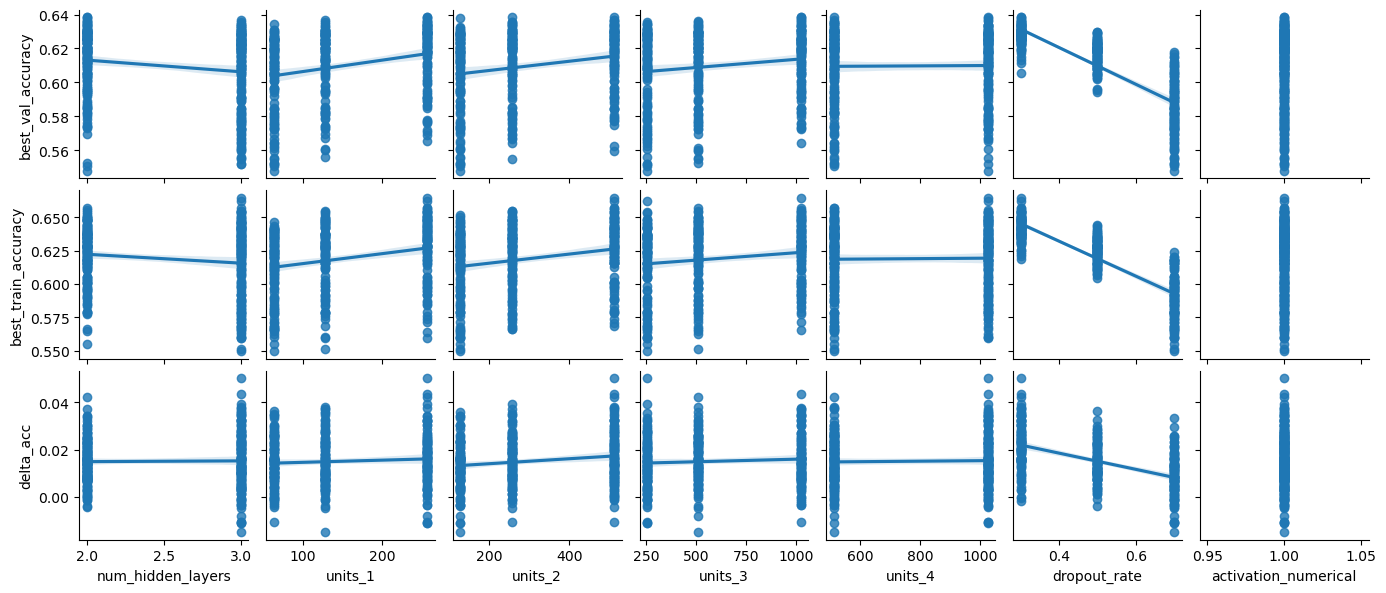

In [52]:
import seaborn as sns
import numpy as np

# Mapping der activation_function auf numerische Werte
activation_mapping = {'relu': 0, 'LeakyReLU': 1}
resultsDF['activation_numerical'] = resultsDF['activation_function'].map(activation_mapping)

x_vars = [
    'num_hidden_layers',
    'units_1',
    'units_2',
    'units_3',
    'units_4',
    'dropout_rate',
    'activation_numerical'
]

y_vars = [
    'best_val_accuracy',
    'best_train_accuracy',
    'delta_acc'
]

sns.pairplot(resultsDF, x_vars=x_vars, y_vars=y_vars, kind='reg', height=2)


In [53]:
def calculate_score(row):
    # Bestmöglicher Score ist 
    best_score = 1.0
    
    # Berechnung des Scores basierend auf Delta-Accuracy und Best Validation Accuracy
    delta_acc_score = 1.0 - abs(row['delta_acc'])  # Je kleiner das Delta, desto besser der Score
    best_val_acc_score = row['best_val_accuracy']  # Je größer die Best Validation Accuracy, desto besser der Score
    
    #Gewichte
    w1=0.1
    w2=1
    
    # Gesamtscore berechnen
    score = (w1 * delta_acc_score + w2 * best_val_acc_score) / 2
    
    # Normalisierung des Scores auf den Bereich [0, 1]
    normalized_score = score / best_score
    
    return normalized_score

# Score-Spalte hinzufügen
resultsDF['score'] = resultsDF.apply(calculate_score, axis=1)
resultsDF = resultsDF.sort_values('score', ascending=False)
resultsDF.head()

,num_hidden_layers,activation_function,dropout_rate,units_1,units_2,units_3,units_4,best_val_accuracy,val_accuracy_std,best_val_loss,val_loss_std,best_train_accuracy,train_accuracy_std,best_train_loss,train_loss_std,delta_acc,activation_numerical,score
52,2,LeakyReLU,0.3,256,512,1024,512,0.638381,0.009601,0.987736,0.012534,0.648993,0.026255,0.930752,0.066736,0.016622,1,0.368360
47,2,LeakyReLU,0.3,256,256,1024,1024,0.638384,0.014609,0.979943,0.027996,0.650730,0.009378,0.921770,0.020560,0.019339,1,0.368225
41,2,LeakyReLU,0.3,256,128,1024,1024,0.637750,0.011157,0.987952,0.028502,0.648038,0.004992,0.933693,0.017118,0.016132,1,0.368068
34,2,LeakyReLU,0.3,128,512,1024,512,0.636799,0.012253,0.994805,0.027382,0.652154,0.003845,0.934218,0.017900,0.024112,1,0.367194
30,2,LeakyReLU,0.3,128,512,256,512,0.634582,0.011646,1.010576,0.003619,0.636324,0.017777,0.963226,0.053366,0.002746,1,0.367154


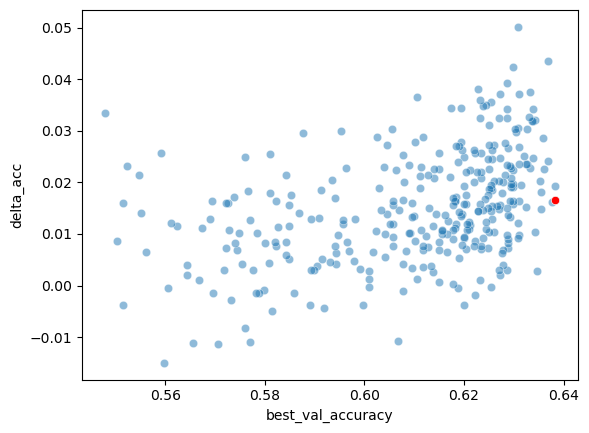

In [57]:
best_params = resultsDF.head(1)

# Scatterplot erstellen
sns.scatterplot(data=resultsDF, x='best_val_accuracy', y='delta_acc', alpha=0.5)
sns.scatterplot(data=best_params, x='best_val_accuracy', y='delta_acc', color='red')

# Achsentitel hinzufügen
plt.xlabel('best_val_accuracy')
plt.ylabel('delta_acc')

# Plot anzeigen
plt.show()


## hier das hoffentlich beste Modell

In [58]:
best_params = resultsDF.iloc[1]
best_model = build_model_from_params(best_params)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                1280      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 512)              

In [59]:
model = Sequential()
model.add(Dense(units=256, activation='LeakyReLU', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='LeakyReLU'))
model.add(Dropout(0.3))
model.add(Dense(units=1024, activation='LeakyReLU'))
model.add(Dropout(0.3))
model.add(Dense(units=1024, activation='LeakyReLU'))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)

In [60]:
batch_size = 512
nb_epoch = 300

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', min_lr=1e-7)

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

Epoch 1/300
7/7 [==============================] - 1s 64ms/step - loss: 1.3682 - accuracy: 0.4471 - val_loss: 1.0261 - val_accuracy: 0.6182 - lr: 0.0010
Epoch 2/300
7/7 [==============================] - 0s 44ms/step - loss: 1.1030 - accuracy: 0.5975 - val_loss: 0.9679 - val_accuracy: 0.6137 - lr: 0.0010
Epoch 3/300
7/7 [==============================] - 0s 44ms/step - loss: 1.0276 - accuracy: 0.6140 - val_loss: 0.9546 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 4/300
7/7 [==============================] - 0s 42ms/step - loss: 0.9994 - accuracy: 0.6165 - val_loss: 0.9333 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 5/300
7/7 [==============================] - 0s 41ms/step - loss: 0.9838 - accuracy: 0.6172 - val_loss: 0.9324 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 6/300
7/7 [==============================] - 0s 44ms/step - loss: 0.9718 - accuracy: 0.6235 - val_loss: 0.9128 - val_accuracy: 0.6448 - lr: 0.0010
Epoch 7/300
7/7 [==============================] - 0s 40ms/step - loss: 0.9559 - a

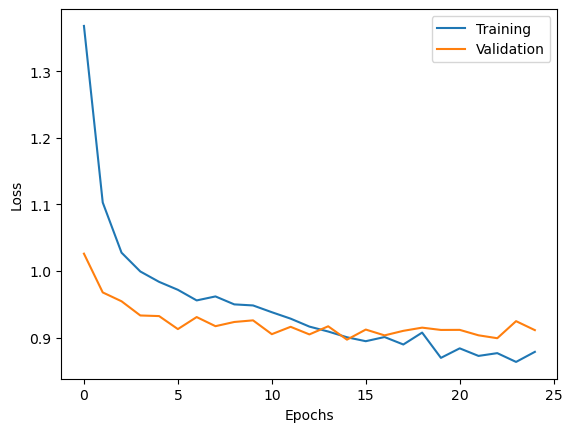

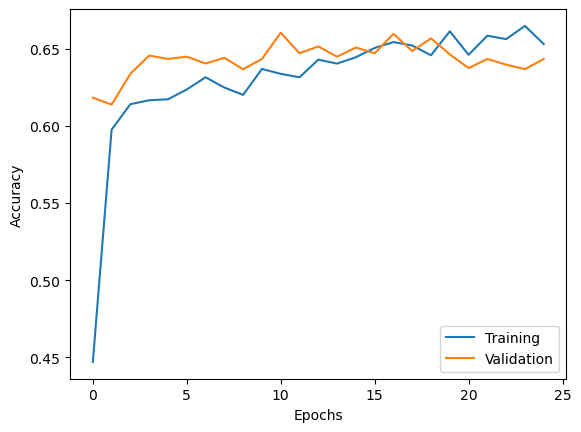

In [61]:
plot_history(hist)

In [62]:
Y_pred = model.predict(X_test)

61/61 [==============================] - 0s 3ms/step


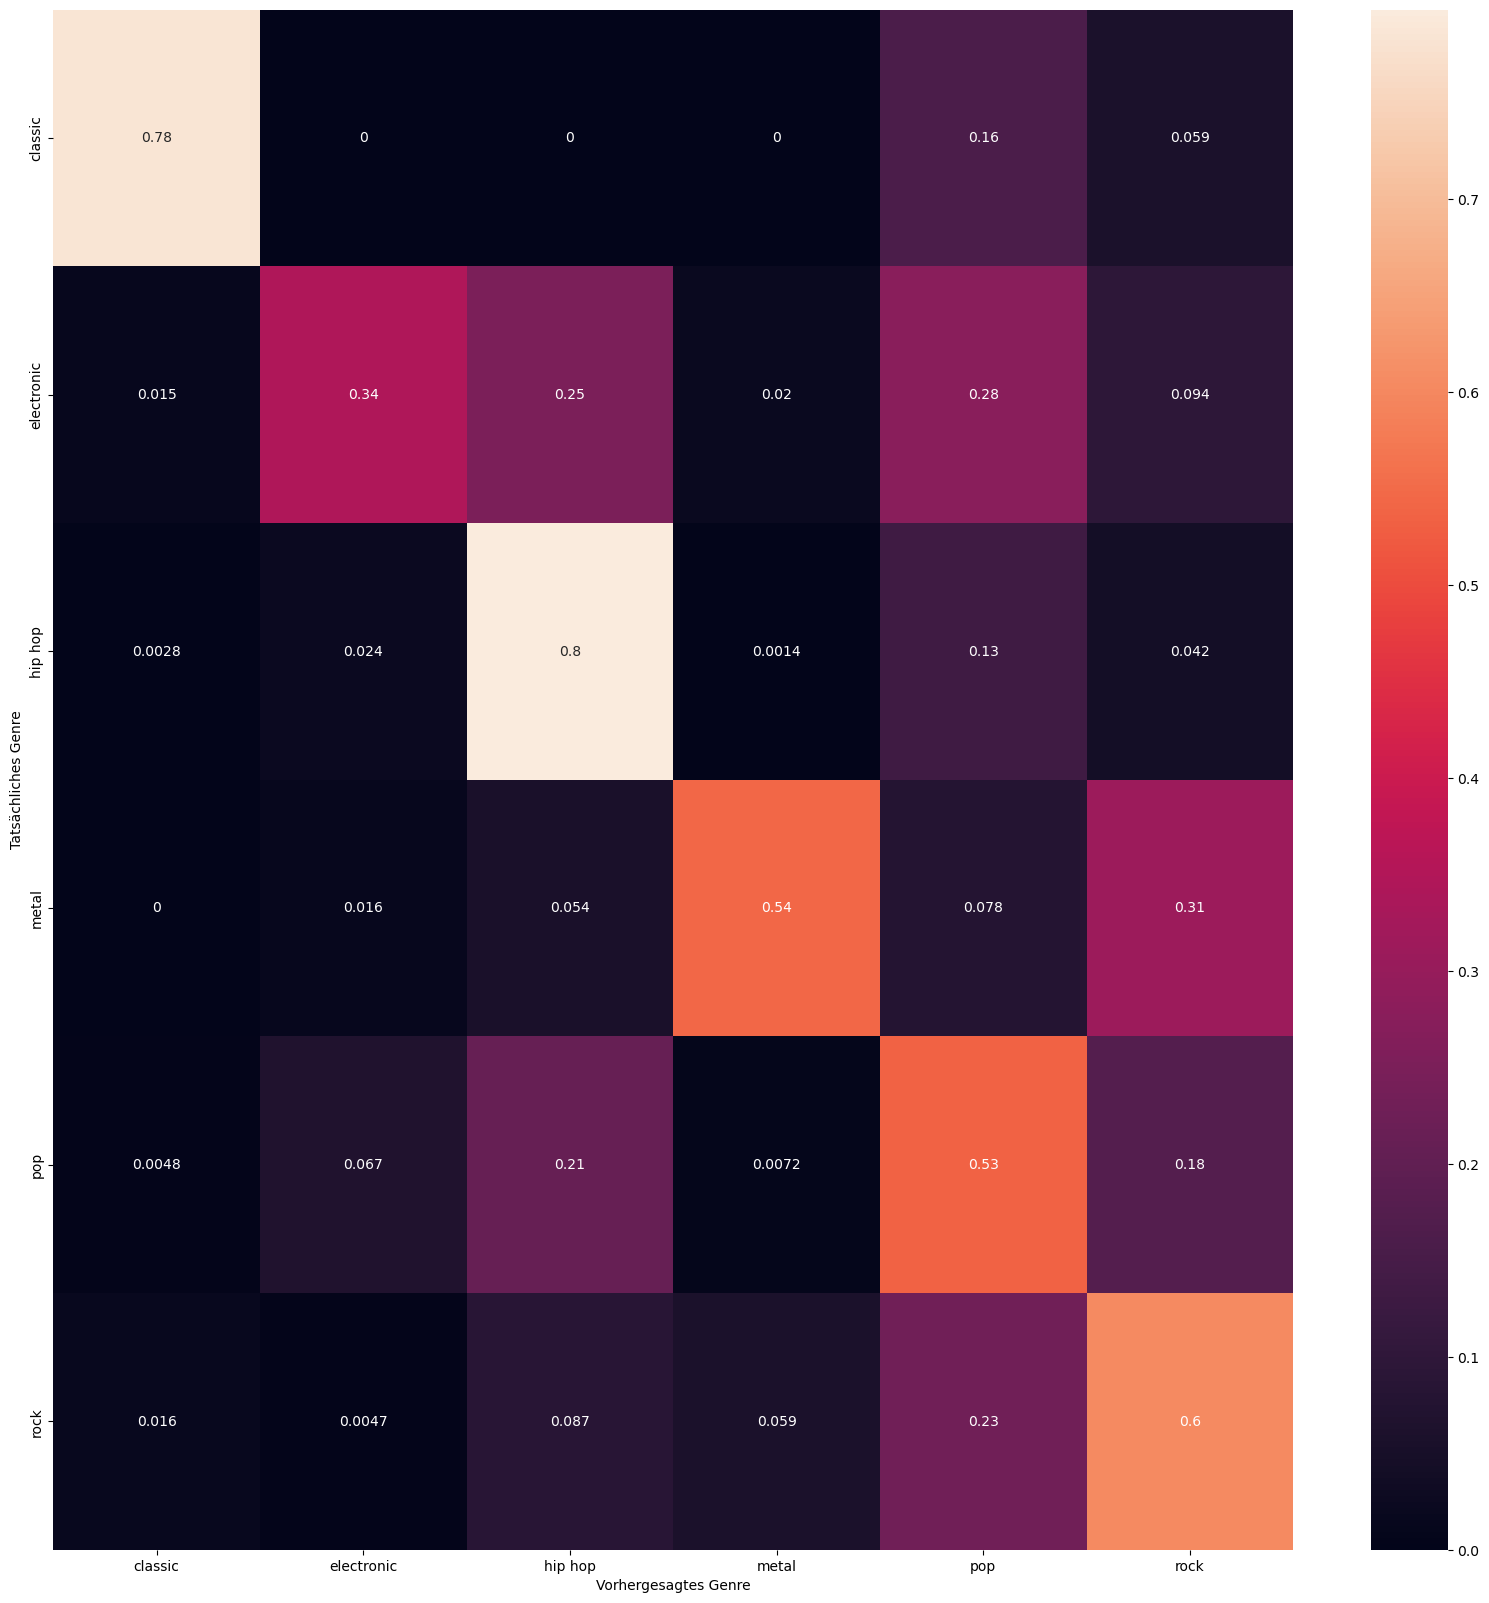

In [63]:
Y_pred_classes = np.argmax(Y_pred, axis=1)

for i in range(len(Y_pred_classes)):
    if label[Y_pred_classes[i]] == 'pop' and Y_pred[i, Y_pred_classes[i]] > 0.9:
        # Finde den Index des zweithöchsten Werts
        second_highest_index = np.argsort(Y_pred[i])[-2]
        Y_pred_classes[i] = second_highest_index
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.savefig('../figures/confusion_matrix.png')
plt.show()

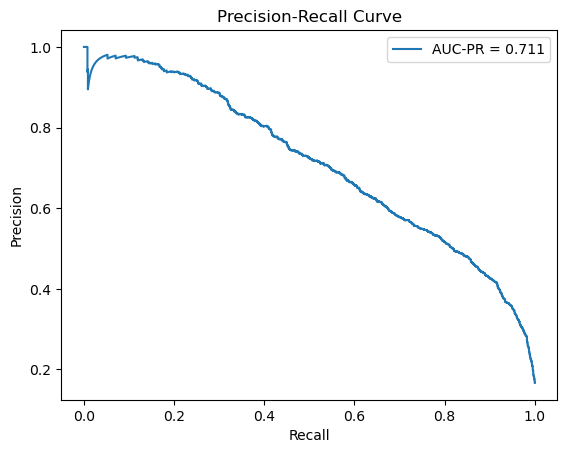

In [64]:
Y_prob = Y_pred

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_prob, pd.DataFrame):
    Y_prob = Y_prob.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

hip hop: AUC-PR = 0.865
classic: AUC-PR = 0.81
metal: AUC-PR = 0.671
rock: AUC-PR = 0.654
electronic: AUC-PR = 0.476
pop: AUC-PR = 0.47


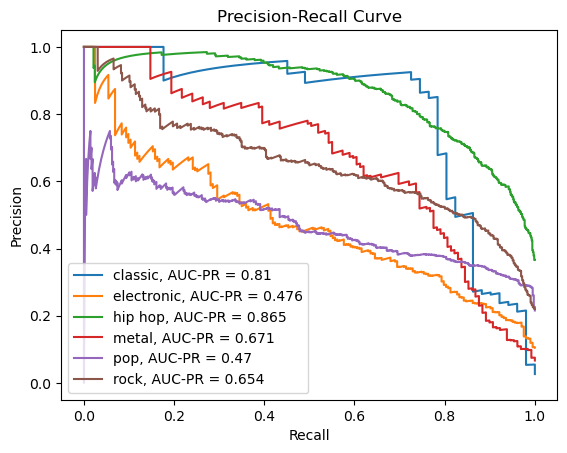

In [65]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")